Importing libraries that we will need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [4]:
df = pd.read_csv('/content/Fraud.csv') #here i imported data..

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [6]:
df.describe()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,42271.000000,4.227100e+04,4.227100e+04,4.227100e+04,4.227000e+04,4.227000e+04,42270.000000,42270.0
mean,7.171087,1.490108e+05,7.727734e+05,7.874065e+05,8.450982e+05,1.158405e+06,0.002224,0.0
std,2.118037,3.145005e+05,2.284003e+06,2.321941e+06,2.466743e+06,2.960508e+06,0.047105,0.0
min,1.000000,1.770000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,7.000000,7.031875e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,8.000000,2.751283e+04,1.856733e+04,3.339900e+02,0.000000e+00,0.000000e+00,0.000000,0.0
75%,8.000000,1.794321e+05,1.421965e+05,1.500335e+05,4.337969e+05,8.013660e+05,0.000000,0.0
max,9.000000,1.000000e+07,2.854724e+07,2.861740e+07,2.958454e+07,3.130692e+07,1.000000,0.0


I AM SELECTING VARIABLES BASED ON THE IMPORTANCE AND THEIR VALUE FLUCTUATIONS. I AM DROPPING OUT ONLY TWO COLUMNS THAT DOES NOT HOLD MUCH SIGNIFICANCE

In [7]:
df= df.drop(['nameOrig', 'nameDest'], axis=1) #dropping these columns as they don't hold significance as they are just the identifiers

HANDLING MISSING VALUES

In [8]:
df.isnull().sum() #the output shows there are missing values

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

In [9]:
#handle missing numerical values
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
imputer = SimpleImputer(strategy='mean')
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])


In [10]:
#handle missing categorical values
categorical_columns = ['type']
for column in categorical_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [11]:
df = df.dropna(subset=['isFraud', 'isFlaggedFraud'])

In [12]:
df.isnull().sum() #NOW WE CAN SEE THERE ARE NO MISSING VALUES LEFT

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [13]:
def handle_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [14]:
df = handle_outliers(df, numerical_columns)

In [15]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [16]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MODEL CREATION... I WILL BE USING MULTIPLE MODELS AND THEN COMPARE THEIR ACCURACIES TO FIGURE OUT THE MOST SUITABLE MODEL

In [19]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Support Vector Machine': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [20]:
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n {classification_report(y_test, y_pred)}\n")

Model: Random Forest
Accuracy: 0.9984622663827774
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8430
         1.0       0.92      0.50      0.65        24

    accuracy                           1.00      8454
   macro avg       0.96      0.75      0.82      8454
weighted avg       1.00      1.00      1.00      8454


Model: Logistic Regression
Accuracy: 0.9971611071682044
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8430
         1.0       0.00      0.00      0.00        24

    accuracy                           1.00      8454
   macro avg       0.50      0.50      0.50      8454
weighted avg       0.99      1.00      1.00      8454




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Support Vector Machine
Accuracy: 0.9971611071682044
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8430
         1.0       0.00      0.00      0.00        24

    accuracy                           1.00      8454
   macro avg       0.50      0.50      0.50      8454
weighted avg       0.99      1.00      1.00      8454




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: K-Nearest Neighbors
Accuracy: 0.9970428199668796
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8430
         1.0       0.33      0.04      0.07        24

    accuracy                           1.00      8454
   macro avg       0.67      0.52      0.54      8454
weighted avg       1.00      1.00      1.00      8454




In [23]:
accuracies = {}
precisions = {}
recalls = {}
f1_scores = {}
roc_auc_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    accuracies[name] = accuracy
    precisions[name] = precision
    recalls[name] = recall
    f1_scores[name] = f1
    roc_auc_scores[name] = roc_auc

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC Score: {roc_auc}")
    print(f"Classification Report:\n {classification_report(y_test, y_pred)}\n")

Model: Random Forest
Accuracy: 0.9984622663827774
Precision: 0.9230769230769231
Recall: 0.5
F1 Score: 0.6486486486486487
ROC-AUC Score: 0.7499406880189798
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8430
         1.0       0.92      0.50      0.65        24

    accuracy                           1.00      8454
   macro avg       0.96      0.75      0.82      8454
weighted avg       1.00      1.00      1.00      8454




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

Model: Logistic Regression
Accuracy: 0.9971611071682044
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC-AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8430
         1.0       0.00      0.00      0.00        24

    accuracy                           1.00      8454
   macro avg       0.50      0.50      0.50      8454
weighted avg       0.99      1.00      1.00      8454




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

Model: Support Vector Machine
Accuracy: 0.9971611071682044
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC-AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8430
         1.0       0.00      0.00      0.00        24

    accuracy                           1.00      8454
   macro avg       0.50      0.50      0.50      8454
weighted avg       0.99      1.00      1.00      8454


Model: K-Nearest Neighbors
Accuracy: 0.9970428199668796
Precision: 0.3333333333333333
Recall: 0.041666666666666664
F1 Score: 0.07407407407407407
ROC-AUC Score: 0.520714709371293
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8430
         1.0       0.33      0.04      0.07        24

    accuracy                           1.00      8454
   macro avg       0.67      0.52      0.54      8454
weighted avg       1.00      1.00      1.00      8454



IT IS EVIDENT THAT ALL THE MODELS ARE PERFORMING VERY NICELY...SO I WILL TRY TO FIND THE BEST AMONG THEM

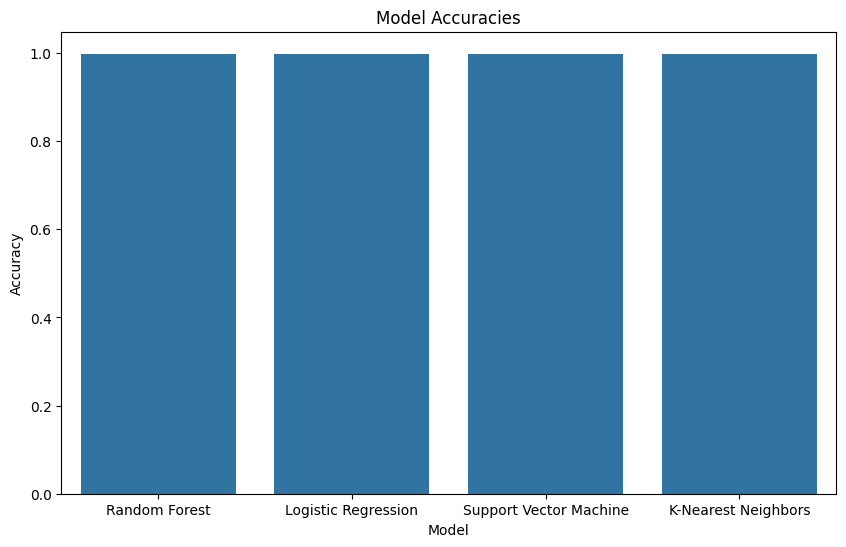

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

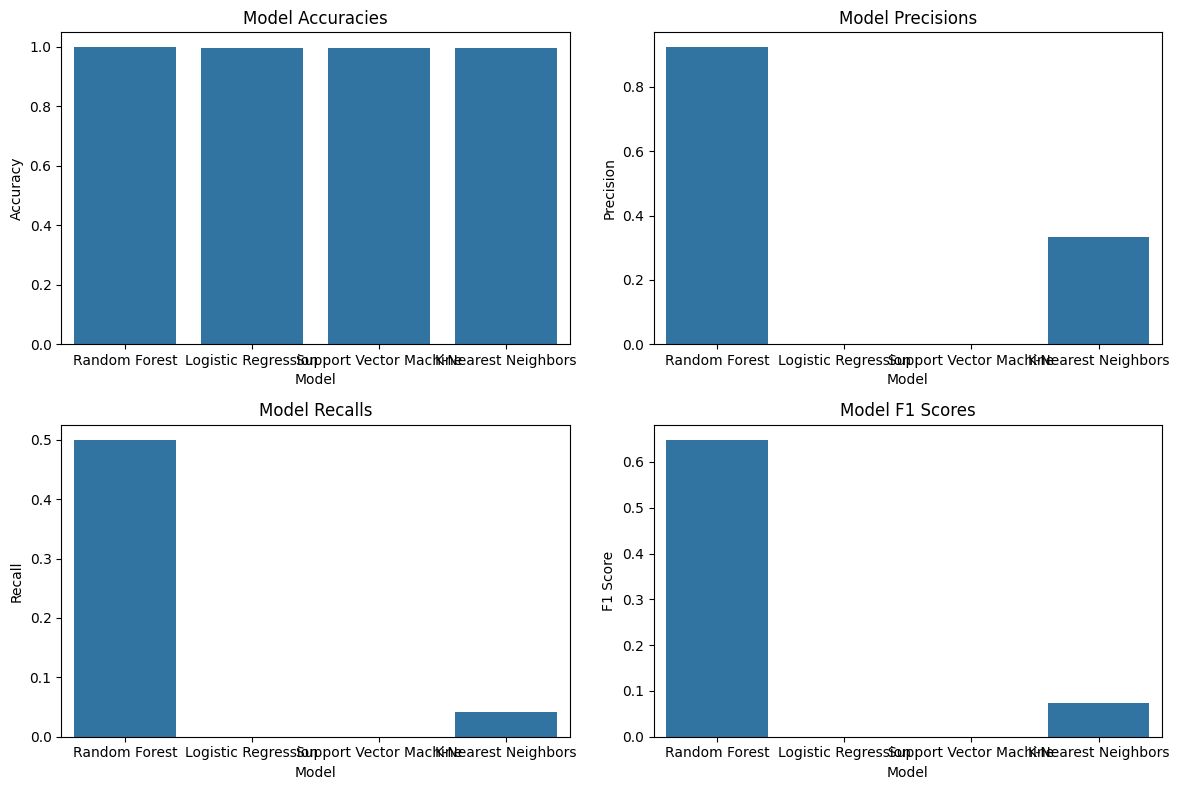

In [25]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')

plt.subplot(2, 2, 2)
sns.barplot(x=list(precisions.keys()), y=list(precisions.values()))
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Model Precisions')

plt.subplot(2, 2, 3)
sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Model Recalls')

plt.subplot(2, 2, 4)
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Model F1 Scores')

plt.tight_layout()
plt.show()


In [26]:
best_model_name = max(accuracies, key=accuracies.get)
best_model_accuracy = accuracies[best_model_name]
print(f"The best model is {best_model_name} with an accuracy of {best_model_accuracy}")

The best model is Random Forest with an accuracy of 0.9984622663827774


ABOVE CODE TELLS ME THAT RANDOM FOREST IS THE BEST ALGORITHM FOR OUR TASK

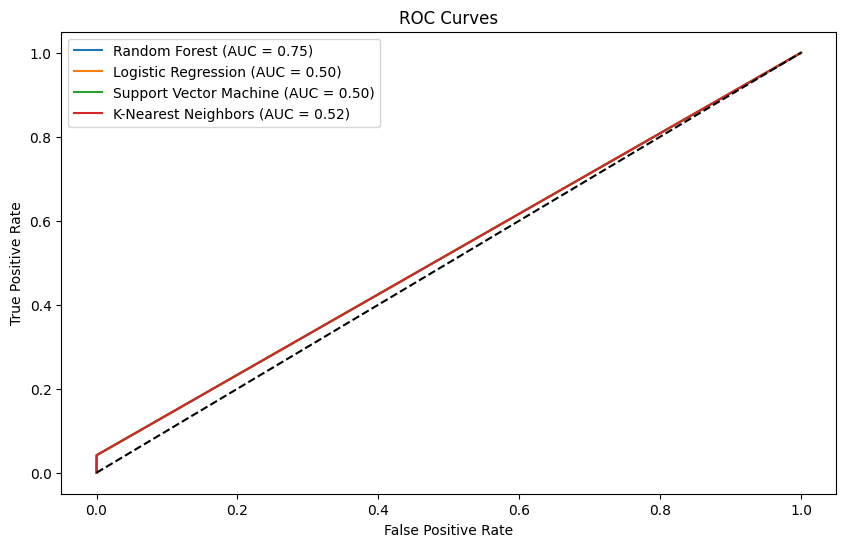

The best model is Random Forest with an accuracy of 0.9984622663827774


In [27]:
plt.figure(figsize=(10, 6))
for name, model in models.items():
    #y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# I then determined the best model
best_model_name = max(accuracies, key=accuracies.get)
best_model_accuracy = accuracies[best_model_name]
print(f"The best model is {best_model_name} with an accuracy of {best_model_accuracy}")

key factors that predict fraudulent customers

In [30]:
importances = models['Random Forest'].feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [32]:
importances = models['Random Forest'].feature_importances_
df_X = pd.DataFrame(X)
features = df_X.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

    Feature  Importance
2         2    0.210844
1         1    0.200691
4         4    0.193128
5         5    0.189027
0         0    0.114018
10       10    0.036416
3         3    0.028265
7         7    0.017809
9         9    0.008720
8         8    0.001083
6         6    0.000000
